In [1]:
import webbpsf
import jax.numpy as np
import matplotlib.pyplot as plt

plt.rcParams['image.origin'] = 'lower'

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-059 CANNOT BE CHECKED AGAINST ONLINE VERSION


In [2]:
from optics import NIRISSOptics
from bases import generate_jwst_hexike_bases

Bases = generate_jwst_hexike_bases(nterms=10, AMI=True, AMI_type='full')
osys = NIRISSOptics(wf_npixels=Bases.npix, bases=Bases)

TypeError: Can't instantiate abstract class HexikeBases with abstract method __call__

In [1]:
osys

NameError: name 'osys' is not defined

In [4]:
Bases

HexikeBases(
  pixel_scale=0.0064486953125,
  npix=1024,
  nterms=10,
  bases=f32[7,10,1024,1024],
  transmission=f32[1024,1024]
)

In [2]:
webbpsfobj = webbpsf.NIRISS()
webbpsfobj.pupil_mask = "MASK_NRM"
niriss_osys = webbpsfobj.get_optical_system()

opd = 1e9 * np.flip(niriss_osys.planes[0].opd)
transmission = niriss_osys.planes[3].amplitude

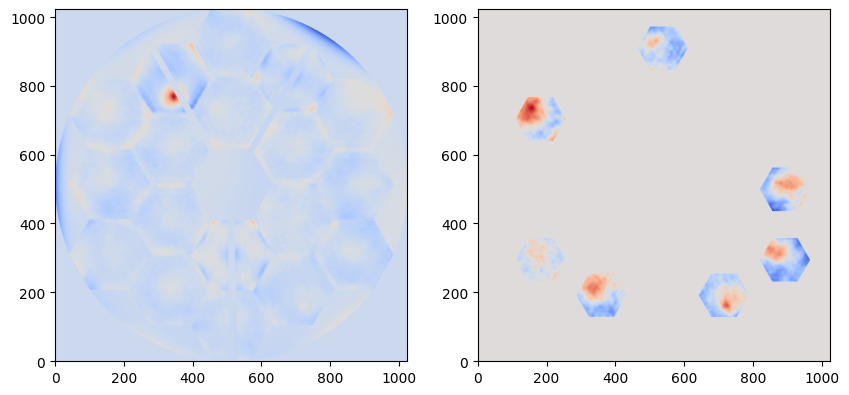

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(opd, cmap="coolwarm")
ax[1].imshow(transmission * opd, cmap="coolwarm")
plt.show()

In [4]:
from bases import jwst_hexike_bases
bases, mask, pscale = jwst_hexike_bases(nterms=10, AMI=True, AMI_type='shifted')

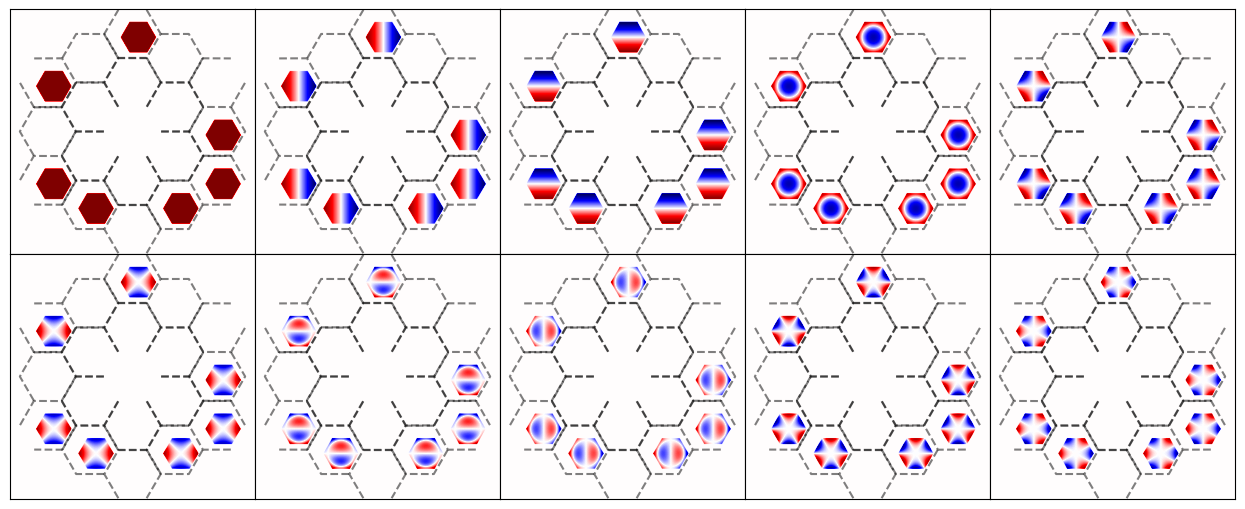

In [5]:
from utils import plot_bases
plot_bases(bases, pscale, edges=True)

# Making fake aberrations

In [6]:
import jax.random as jr
fake_coeffs = jr.normal(jr.PRNGKey(0), bases.shape[:2])
print(f'Fake coeffs shape: {fake_coeffs.shape}')

Fake coeffs shape: (7, 10)


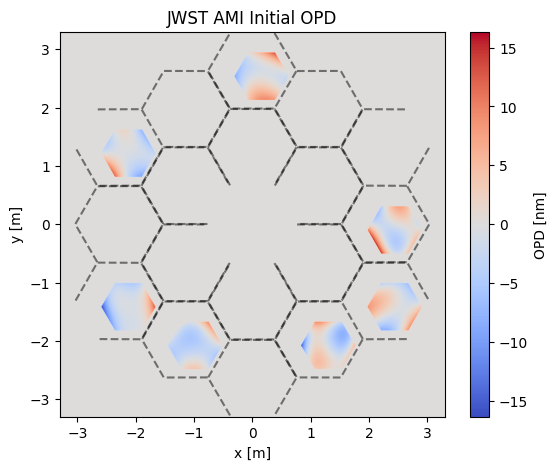

In [11]:
from bases import scale_bases
from utils import plot_opd

fake_opd = scale_bases(fake_coeffs, bases)
plot_opd(fake_opd, pscale, mask=mask)

In [8]:
def loss_fn(flat_coeffs, bases, data):
    coeffs = flat_coeffs.reshape(*bases.shape[:2])
    opd = scale_bases(coeffs, bases)
    
    return np.sum((opd - data)**2)

initial_coeffs = jr.normal(jr.PRNGKey(1), bases.shape[:2])

In [9]:
%%time
loss = loss_fn(initial_coeffs, bases, fake_opd) # Compile
print("Initial Loss: {}".format(loss))

Initial Loss: 2835318.25
CPU times: user 270 ms, sys: 28.1 ms, total: 298 ms
Wall time: 76.4 ms


In [10]:
import zodiax as zdx
import optax
optim, opt_state = zdx.get_optimiser(scale_bases, param, optax.adam(1e-8))

NameError: name 'param' is not defined

In [ ]:
opt_opd = scale_bases(result.x.reshape(*bases.shape[:2]), bases)
plot_opd(1e9 * opt_opd, pscale, mask=mask)

In [ ]:
np.allclose(opt_opd, fake_opd)

In [ ]:
plt.imshow(1e9*(opt_opd - fake_opd), cmap="coolwarm")
plt.colorbar()

In [1]:
import dLux as dl
